# gpusvf (production-version)
A GPU-accelerated algorithm for calculating sky view factor for a given DSM and tree layer

In [1]:
import os, os.path
import rasterio as rio
from osgeo import gdal
from osgeo.gdalconst import *
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import time
import math
import struct


dsmfile = demfile = r"E:\Code\gpusvf\gpusvf\test_data\BG_1F.tif"	# DSM 文件(Ground + Building)
treefile = r"E:\Code\gpusvf\gpusvf\test_data\Vege_1F.tif"			# Vege 文件(Tree)


with rasterio.open(dsmfile) as dsmlayer:
    dsmimg = dsmlayer.read(1)
with rasterio.open(treefile) as treelayer:
    treeimg = treelayer.read(1)

gdal_dsm = gdal.Open(dsmfile)
dsm = gdal_dsm.ReadAsArray().astype(float)
tree = treeimg.astype(float)
geotransform = gdal_dsm.GetGeoTransform()
scale = 1 / geotransform[1]

# 处理 NoData 值
nodata_value = -3.4028234663852886e+38
dsm = np.where(dsm == nodata_value, np.nan, dsm)
tree = np.where(tree < 0, 0, tree)

# 用邻近值插值 NaN 值，或者简单地设置为平均高程
if np.isnan(dsm).any():
    valid_data = dsm[~np.isnan(dsm)]
    if len(valid_data) > 0:
        min_valid = np.min(valid_data)
        dsm = np.where(np.isnan(dsm), min_valid, dsm)

if np.isnan(tree).any():
    valid_data = tree[~np.isnan(tree)]
    if len(valid_data) > 0:
        min_valid = np.min(valid_data)
        tree = np.where(np.isnan(tree), min_valid, tree)

print(f"DSM shape: {dsm.shape}, Tree shape: {tree.shape}")
print(f"DSM value range: {np.min(dsm)} to {np.max(dsm)}, Tree value range: {np.min(tree)} to {np.max(tree)}")
print(f"GeoTransform: {geotransform}")
print(f"Scale: {scale}")


DSM shape: (2001, 2001), Tree shape: (2001, 2001)
DSM value range: -1.0700000524520874 to 24.65987205505371, Tree value range: 0.0 to 13.632522583007812
GeoTransform: (42012.5, 0.5, 0.0, 25352.5, 0.0, -0.5)
Scale: 2.0


d:\ProgramData\anaconda3\envs\gpusvf\lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


# Cupy-version

In [2]:
# Block 1: 检测CuPy是否正确安装以及配置
import cupy as cp
import numpy as np

# 检查CUDA是否可用
print("CuPy version:", cp.__version__)
print("CUDA available:", cp.cuda.is_available())

if cp.cuda.is_available():
    # 显示GPU信息
    device = cp.cuda.Device()
    print("GPU device count:", cp.cuda.runtime.getDeviceCount())
    print("Current device:", device.id)
    print("Total memory:", device.mem_info[1] / (1024**3), "GB")
    print("Free memory:", device.mem_info[0] / (1024**3), "GB")
    
    # 简单测试
    a_cp = cp.array([1, 2, 3, 4, 5])
    b_cp = cp.array([6, 7, 8, 9, 10])
    c_cp = a_cp + b_cp
    print("CuPy test result:", c_cp)
    print("Test successful!")
else:
    print("CUDA is not available. Please check your CuPy installation.")

CuPy version: 13.6.0
CUDA available: True
GPU device count: 1
Current device: 0
Total memory: 11.99951171875 GB
Free memory: 10.8125 GB
CuPy test result: [ 7  9 11 13 15]
Test successful!


In [3]:
# Block 2: GPU编码文件
import cupy as cp

# 全面升级的CUDA核函数，以匹配参考代码的复杂输出需求
svf_shadowcasting_kernel_code = r'''
#define PI 3.1415926f
#define OCCLUSION_NONE 0
#define OCCLUSION_BUILDING 1
#define OCCLUSION_VEGETATION 2

__device__ float annulus_weight(float altitude, float aziinterval) {
    float n = 90.0f;
    float steprad = (360.0f/aziinterval) * PI/180.0f;
    float annulus = 91.0f - altitude;
    float w = 1.0f/(2.0f*PI) * sinf(PI / (2.0f*n)) * sinf((PI * (2.0f * annulus - 1.0f)) / (2.0f * n));
    return steprad * w;
}

// 升级的光线追踪辅助函数
// 它现在能判断遮挡物的类型（建筑或植被）
__device__ void trace_ray_detailed(
    int x, int y, int imageW, int imageH,
    float altitude_rad, float theta, float scale, int rangeDist,
    float* dsm_Latt, float* tree_Latt, float veg_transmittance,
    float& sh, float& vegsh, float& vbshvegsh)
{
    float h_orig = dsm_Latt[x + y * imageW];
    float f = h_orig;
    int occlusion_type = OCCLUSION_NONE;

    for (float radius = 1.0f; radius < rangeDist; radius += 1.0f) {
        float x_f = x + radius * cosf(theta);
        float y_f = y - radius * sinf(theta);

        if (x_f < 0.0f || x_f >= imageW - 1.0f || y_f < 0.0f || y_f >= imageH - 1.0f) break;

        int x1 = (int)floorf(x_f);
        int y1 = (int)floorf(y_f);
        float x_frac = x_f - x1;
        float y_frac = y_f - y1;

        // 插值计算建筑物+地面高度
        float h11_b = dsm_Latt[x1 + y1 * imageW];
        float h12_b = dsm_Latt[x1 + (y1 + 1) * imageW];
        float h21_b = dsm_Latt[(x1 + 1) + y1 * imageW];
        float h22_b = dsm_Latt[(x1 + 1) + (y1 + 1) * imageW];
        float h_top_b = h11_b * (1.0f - x_frac) + h21_b * x_frac;
        float h_bottom_b = h12_b * (1.0f - x_frac) + h22_b * x_frac;
        float height_b = h_top_b * (1.0f - y_frac) + h_bottom_b * y_frac;

        // 插值计算植被高度
        float h11_t = tree_Latt[x1 + y1 * imageW];
        float h12_t = tree_Latt[x1 + (y1 + 1) * imageW];
        float h21_t = tree_Latt[(x1 + 1) + y1 * imageW];
        float h22_t = tree_Latt[(x1 + 1) + (y1 + 1) * imageW];
        float h_top_t = h11_t * (1.0f - x_frac) + h21_t * x_frac;
        float h_bottom_t = h12_t * (1.0f - x_frac) + h22_t * x_frac;
        float height_t = h_top_t * (1.0f - y_frac) + h_bottom_t * y_frac;
        
        // 总高度 = 建筑+地面 + 植被
        float total_height = height_b + height_t;

        float temp = total_height - radius * tanf(altitude_rad) / scale;
        if (f < temp) {
            f = temp;
            // 判断造成最高遮挡的是建筑还是植被
            float ray_height_at_obstruction = h_orig + radius * tanf(altitude_rad) / scale;
            if (ray_height_at_obstruction < height_b) {
                occlusion_type = OCCLUSION_BUILDING;
            } else {
                occlusion_type = OCCLUSION_VEGETATION;
            }
        }
    }

    if (occlusion_type == OCCLUSION_NONE) {
        sh = 1.0f;
        vegsh = 1.0f;
        vbshvegsh = 1.0f;
    } else if (occlusion_type == OCCLUSION_BUILDING) {
        sh = 0.0f;
        vegsh = 1.0f; // 射线被建筑挡住，视为没有植被遮挡
        vbshvegsh = 0.0f;
    } else { // OCCLUSION_VEGETATION
        sh = 1.0f; // 射线被植被挡住，视为没有建筑遮挡
        vegsh = veg_transmittance; // 植被有透光率
        vbshvegsh = veg_transmittance;
    }
}


extern "C" __global__ void svf_shadowcasting_cupy(
    // 18个输出数组
    float* svf, float* svfE, float* svfS, float* svfW, float* svfN,
    float* svfveg, float* svfEveg, float* svfSveg, float* svfWveg, float* svfNveg,
    float* svfaveg, float* svfEaveg, float* svfSaveg, float* svfWaveg, float* svfNaveg,
    float* shmat, float* vegshmat, float* vbshvegshmat,
    // 4个输入
    float* dsm_Latt, float* tree_Latt, float scale, int imageW, int imageH, int rangeDist, float veg_transmittance)
{
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;

    if (x >= imageW || y >= imageH) return;

    int index_2d = x + y * imageW;
    
    // 如果当前位置有树，所有SVF都设为0.03
    if (tree_Latt[index_2d] > 0.0f) {
        svf[index_2d] = svfE[index_2d] = svfS[index_2d] = svfW[index_2d] = svfN[index_2d] = 0.03f;
        svfveg[index_2d] = svfEveg[index_2d] = svfSveg[index_2d] = svfWveg[index_2d] = svfNveg[index_2d] = 0.03f;
        svfaveg[index_2d] = svfEaveg[index_2d] = svfSaveg[index_2d] = svfWaveg[index_2d] = svfNaveg[index_2d] = 0.03f;
        for (int i=0; i < 145; i++) {
            int index_3d = i * imageH * imageW + index_2d;
            shmat[index_3d] = 0.0f;
            vegshmat[index_3d] = 0.0f;
            vbshvegshmat[index_3d] = 0.0f;
        }
        return;
    }

    // 穹顶参数
    float iangle[8] = {6, 18, 30, 42, 54, 66, 78, 90};
    float aziinterval[8] = {30, 30, 24, 24, 18, 12, 6, 1};
    float annulino[9] = {0, 12, 24, 36, 48, 60, 72, 84, 90};
    float aziintervalaniso[8] = {15, 15, 12, 12, 9, 6, 3, 1};

    // 初始化所有SVF局部变量
    float l_svf=0.f, l_svfE=0.f, l_svfS=0.f, l_svfW=0.f, l_svfN=0.f;
    float l_svfveg=0.f, l_svfEveg=0.f, l_svfSveg=0.f, l_svfWveg=0.f, l_svfNveg=0.f;
    float l_svfaveg=0.f, l_svfEaveg=0.f, l_svfSaveg=0.f, l_svfWaveg=0.f, l_svfNaveg=0.f;
    
    int idx = 0;
    for (int i = 0; i < 8; i++) {
        for (int j = 0; j < (int)aziinterval[i]; j++) {
            float altitude = iangle[i];
            float azimuth = j * (360.0f/aziinterval[i]);
            float altitude_rad = PI * altitude / 180.0f;
            float theta = (azimuth < 90.0f && azimuth >= 0.0f) ? PI * (90.0f - azimuth) / 180.0f : PI * (450.0f - azimuth) / 180.0f;

            float sh, vegsh, vbshvegsh;
            trace_ray_detailed(x, y, imageW, imageH, altitude_rad, theta, scale, rangeDist, dsm_Latt, tree_Latt, veg_transmittance, sh, vegsh, vbshvegsh);
            
            int index_3d = idx * imageH * imageW + index_2d;
            shmat[index_3d] = sh;
            vegshmat[index_3d] = vegsh;
            vbshvegshmat[index_3d] = vbshvegsh;

            for (int k = (int)annulino[i] + 1; k < (int)annulino[i + 1] + 1; k++) {
                float w_iso = annulus_weight((float)k, aziinterval[i]);
                l_svf += w_iso * sh;
                l_svfveg += w_iso * vegsh;
                l_svfaveg += w_iso * vbshvegsh;

                float w_aniso = annulus_weight((float)k, aziintervalaniso[i]);
                if (azimuth >= 0.0f && azimuth < 180.0f) {
                    l_svfE += w_aniso * sh; l_svfEveg += w_aniso * vegsh; l_svfEaveg += w_aniso * vbshvegsh;
                }
                if (azimuth >= 90.0f && azimuth < 270.0f) {
                    l_svfS += w_aniso * sh; l_svfSveg += w_aniso * vegsh; l_svfSaveg += w_aniso * vbshvegsh;
                }
                if (azimuth >= 180.0f && azimuth < 360.0f) {
                    l_svfW += w_aniso * sh; l_svfWveg += w_aniso * vegsh; l_svfWaveg += w_aniso * vbshvegsh;
                }
                if (azimuth >= 270.0f || azimuth < 90.0f) {
                    l_svfN += w_aniso * sh; l_svfNveg += w_aniso * vegsh; l_svfNaveg += w_aniso * vbshvegsh;
                }
            }
            idx++;
        }
    }
    
    // 将结果写回全局内存
    svf[index_2d] = l_svf; svfE[index_2d] = l_svfE; svfS[index_2d] = l_svfS; svfW[index_2d] = l_svfW; svfN[index_2d] = l_svfN;
    svfveg[index_2d] = l_svfveg; svfEveg[index_2d] = l_svfEveg; svfSveg[index_2d] = l_svfSveg; svfWveg[index_2d] = l_svfWveg; svfNveg[index_2d] = l_svfNveg;
    svfaveg[index_2d] = l_svfaveg; svfEaveg[index_2d] = l_svfEaveg; svfSaveg[index_2d] = l_svfSaveg; svfWaveg[index_2d] = l_svfWaveg; svfNaveg[index_2d] = l_svfNaveg;
}
'''

# 重新编译内核
svf_shadowcasting_kernel = cp.RawKernel(svf_shadowcasting_kernel_code, 'svf_shadowcasting_cupy')

In [4]:
# Block 3: 剩下的其他部分
import time

def svfCalculator_ShadowCastingOnGPU(dsm, tree, scale, range_dist, veg_transmittance=0.8): 
    # 将输入数据转换为CuPy数组
    px_bldg = cp.asarray(dsm, dtype=cp.float32)
    px_tree = cp.asarray(tree, dtype=cp.float32)
    
    height, width = px_bldg.shape
    
    # 设置线程块和网格大小
    nb_ThreadsX = 8
    nb_ThreadsY = 8
    nb_blocksX = (width + nb_ThreadsX - 1) // nb_ThreadsX
    nb_blocksY = (height + nb_ThreadsY - 1) // nb_ThreadsY

    # --- 为所有18个输出创建GPU数组 ---
    # Building SVFs
    svf_gpu = cp.empty_like(px_bldg)
    svfE_gpu = cp.empty_like(px_bldg)
    svfS_gpu = cp.empty_like(px_bldg)
    svfW_gpu = cp.empty_like(px_bldg)
    svfN_gpu = cp.empty_like(px_bldg)
    
    # Vegetation SVFs
    svfveg_gpu = cp.empty_like(px_bldg)
    svfEveg_gpu = cp.empty_like(px_bldg)
    svfSveg_gpu = cp.empty_like(px_bldg)
    svfWveg_gpu = cp.empty_like(px_bldg)
    svfNveg_gpu = cp.empty_like(px_bldg)

    # Anisotropic Veg SVFs (combined)
    svfaveg_gpu = cp.empty_like(px_bldg)
    svfEaveg_gpu = cp.empty_like(px_bldg)
    svfSaveg_gpu = cp.empty_like(px_bldg)
    svfWaveg_gpu = cp.empty_like(px_bldg)
    svfNaveg_gpu = cp.empty_like(px_bldg)

    # Shadow Matrices
    shmat_gpu = cp.empty((145, height, width), dtype=cp.float32)
    vegshmat_gpu = cp.empty((145, height, width), dtype=cp.float32)
    vbshvegshmat_gpu = cp.empty((145, height, width), dtype=cp.float32)

    # --- 调用更新后的内核 ---
    svf_shadowcasting_kernel(
        (nb_blocksX, nb_blocksY), 
        (nb_ThreadsX, nb_ThreadsY),
        (
         # 18个输出数组
         svf_gpu, svfE_gpu, svfS_gpu, svfW_gpu, svfN_gpu,
         svfveg_gpu, svfEveg_gpu, svfSveg_gpu, svfWveg_gpu, svfNveg_gpu,
         svfaveg_gpu, svfEaveg_gpu, svfSaveg_gpu, svfWaveg_gpu, svfNaveg_gpu,
         shmat_gpu, vegshmat_gpu, vbshvegshmat_gpu,
         # 4个输入参数
         px_bldg, px_tree, cp.float32(scale), width, height, int(range_dist), cp.float32(veg_transmittance)
        )
    )
    
    cp.cuda.Stream.null.synchronize()
    
    # --- 将所有结果从GPU传回CPU，并组织成字典 ---
    results = {
        "svf": cp.asnumpy(svf_gpu), "svfE": cp.asnumpy(svfE_gpu), "svfS": cp.asnumpy(svfS_gpu), "svfW": cp.asnumpy(svfW_gpu), "svfN": cp.asnumpy(svfN_gpu),
        "svfveg": cp.asnumpy(svfveg_gpu), "svfEveg": cp.asnumpy(svfEveg_gpu), "svfSveg": cp.asnumpy(svfSveg_gpu), "svfWveg": cp.asnumpy(svfWveg_gpu), "svfNveg": cp.asnumpy(svfNveg_gpu),
        "svfaveg": cp.asnumpy(svfaveg_gpu), "svfEaveg": cp.asnumpy(svfEaveg_gpu), "svfSaveg": cp.asnumpy(svfSaveg_gpu), "svfWaveg": cp.asnumpy(svfWaveg_gpu), "svfNaveg": cp.asnumpy(svfNaveg_gpu),
        "shmat": cp.asnumpy(shmat_gpu).transpose(1, 2, 0),
        "vegshmat": cp.asnumpy(vegshmat_gpu).transpose(1, 2, 0),
        "vbshvegshmat": cp.asnumpy(vbshvegshmat_gpu).transpose(1, 2, 0)
    }
    
    return results

# Block 4: 保存为GeoTIFF的函数 (这部分不需要修改)
def saverasternd(gdal_data, filename, raster):
    rows = gdal_data.RasterYSize
    cols = gdal_data.RasterXSize
    
    outDs = gdal.GetDriverByName("GTiff").Create(filename, cols, rows, int(1), GDT_Float32)
    outBand = outDs.GetRasterBand(1)
    
    outBand.WriteArray(raster, 0, 0)
    outBand.FlushCache()
    outBand.SetNoDataValue(-9999)
    
    outDs.SetGeoTransform(gdal_data.GetGeoTransform())
    outDs.SetProjection(gdal_data.GetProjection())
    
    outBand = None
    outDs = None
    gdal_data = None

Processing image with shape: (2001, 2001)
Dynamic search radius: 2829 pixels
The time elapsed is: 7.94 seconds
Saved all 15 SVF maps to E:\\Code\\gpusvf\\gpusvf\\test_data\\output_gpu\svfs_gpu.zip
Saved all 3 shadow matrices to E:\\Code\\gpusvf\\gpusvf\\test_data\\output_gpu\shadowmats_gpu.npz


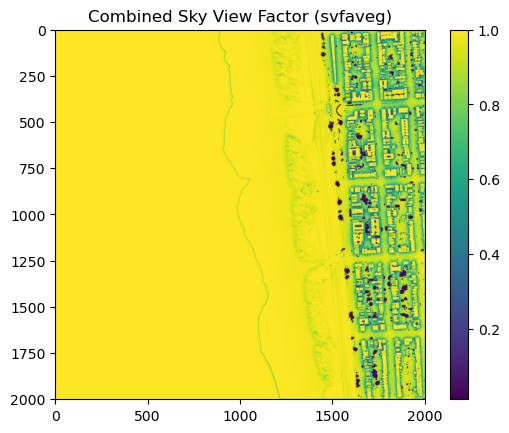

In [5]:
import zipfile
import time

t1 = time.time()

dsm_img = dsm
tree_img = tree

print(f"Processing image with shape: {dsm_img.shape}")

height, width = dsm_img.shape
range_dist = int(np.sqrt(width**2 + height**2))
print(f"Dynamic search radius: {range_dist} pixels")

# 调用GPU函数，它现在返回一个包含所有结果的字典
# veg_transmittance=0.8 表示植被有80%的透光率，你可以根据需要调整
results = svfCalculator_ShadowCastingOnGPU(dsm_img, tree_img, np.float32(scale), range_dist, veg_transmittance=0.8)

# --- 后处理，清理所有SVF结果 ---
svf_keys = [
    'svf', 'svfE', 'svfS', 'svfW', 'svfN',
    'svfveg', 'svfEveg', 'svfSveg', 'svfWveg', 'svfNveg',
    'svfaveg', 'svfEaveg', 'svfSaveg', 'svfWaveg', 'svfNaveg'
]
for key in svf_keys:
    res = results[key]
    # 补偿，与参考代码逻辑一致
    if key in ['svfS', 'svfW', 'svfSveg', 'svfWveg', 'svfSaveg', 'svfWaveg']:
        res += 3.0459e-004
    res = np.where(np.isinf(res), 1.0, res)
    res = np.where(np.isnan(res), 1.0, res)
    results[key] = np.clip(res, 0.0, 1.0)

t2 = time.time()
print(f'The time elapsed is: {t2-t1:.2f} seconds')

output_folder = r"E:\\Code\\gpusvf\\gpusvf\\test_data\\output_gpu"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 1. 保存所有SVF结果到 svfs.zip
zip_path = os.path.join(output_folder, 'svfs_gpu.zip')
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for key in svf_keys:
        temp_tif_path = os.path.join(output_folder, f'{key}_temp.tif')
        saverasternd(gdal.Open(dsmfile), temp_tif_path, results[key])
        zipf.write(temp_tif_path, arcname=f'{key}.tif')
        os.remove(temp_tif_path)
print(f"Saved all 15 SVF maps to {zip_path}")

# 2. 保存所有阴影矩阵到 shadowmats.npz
npz_path = os.path.join(output_folder, 'shadowmats_gpu.npz')
np.savez_compressed(npz_path, 
                    shmat=results['shmat'], 
                    vegshmat=results['vegshmat'], 
                    vbshvegshmat=results['vbshvegshmat'])
print(f"Saved all 3 shadow matrices to {npz_path}")

# --- 可视化综合SVF (svfaveg) ---
plt.imshow(results['svfaveg'])
plt.colorbar()
plt.title("Combined Sky View Factor (svfaveg)")
plt.savefig(os.path.join(output_folder, "svf_combined_gpu.png"), dpi=300)
plt.show()

# 清理GDAL资源
gdal_dsm = None

In [6]:
import numpy as np
b = np.load(r"E:\Code\gpusvf\gpusvf\test_data\output_gpu\shadowmats_gpu.npz")
print(b.files)

['shmat', 'vegshmat', 'vbshvegshmat']
